# Project 4


## 1. Data Ingestion and Preparation



In [1]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = "--conf spark.executorEnv.PYTHONNOUSERSITE=true pyspark-shell"

In [2]:
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Graphs_Practice") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0,graphframes:graphframes:0.8.4-spark3.5-s_2.12") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .getOrCreate()



25/05/09 15:36:10 WARN Utils: Your hostname, markus-XPS-15-9530 resolves to a loopback address: 127.0.1.1; using 192.168.1.114 instead (on interface wlp0s20f3)
25/05/09 15:36:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/markus/.ivy2/cache
The jars for the packages stored in: /home/markus/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-13d1a25c-4437-4d63-846e-64af75deb878;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/markus/kool/BDM_project_group16/env/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found io.delta#delta-core_2.12;2.4.0 in central
	found io.delta#delta-storage;2.4.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found graphframes#graphframes;0.8.4-spark3.5-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 120ms :: artifacts dl 4ms
	:: modules in use:
	graphframes#graphframes;0.8.4-spark3.5-s_2.12 from spark-packages in [default]
	io.delta#delta-core_2.12;2.4.0 from central in [default]
	io.delta#delta-storage;2.4.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   5   |   0   |   0   |   0   ||   5   |   0   |


In [3]:
flight_df = spark.read.csv("2009.csv", header=True, inferSchema=True)
display(flight_df)


DataFrame[FL_DATE: date, OP_CARRIER: string, OP_CARRIER_FL_NUM: int, ORIGIN: string, DEST: string, CRS_DEP_TIME: int, DEP_TIME: double, DEP_DELAY: double, TAXI_OUT: double, WHEELS_OFF: double, WHEELS_ON: double, TAXI_IN: double, CRS_ARR_TIME: int, ARR_TIME: double, ARR_DELAY: double, CANCELLED: double, CANCELLATION_CODE: string, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double, Unnamed: 27: string]

## 2. Cleaning and Preprocessing

In [ ]:
from pyspark.sql.functions import col, year, month, dayofweek, to_date

flight_df = flight_df.withColumn("FL_DATE", to_date(col("FL_DATE"), "yyyy-MM-dd"))
df_2009 = flight_df.filter(year(col("FL_DATE")) == 2009)
renamed_df = df_2009.withColumnRenamed("OP_CARRIER", "UniqueCarrier").withColumnRenamed("OP_CARRIER_FL_NUM", "FlightNum")
df_features = renamed_df.withColumn("DayOfWeek", dayofweek(col("FL_DATE"))) .withColumn("Month", month(col("FL_DATE")))

key_columns = ["UniqueCarrier", "FlightNum", "ORIGIN", "DEST", "CRS_DEP_TIME", "CRS_ARR_TIME"]
df_clean = df_features.dropna(subset=key_columns)

final_df = df_clean.filter(col("DIVERTED") == 0)

# Since we did it mostly on vscode and not the jupyter localhost env, the csvs are kept in the same directory and read as such
# if you prefer to use them in the env, you can use the following code to read them
# output_path = "input/2009_clean"
output_path = "2009_clean"
final_df.write.mode("overwrite").partitionBy("Month", "DayOfWeek").parquet(output_path)

25/05/09 15:36:19 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## 3. Exploratory Analysis

In [ ]:
from pyspark.sql.functions import col, count

df = spark.read.parquet("2009_clean")

top_carriers = df.groupBy("UniqueCarrier").agg(count("*").alias("flight_count")) \
                 .orderBy(col("flight_count").desc())

print("Top 10 Carriers by Flight Count:")
top_carriers.show(10)


Top 10 Carriers by Flight Count:
+-------------+------------+
|UniqueCarrier|flight_count|
+-------------+------------+
|           WN|     1127045|
|           AA|      548194|
|           OO|      544843|
|           MQ|      434577|
|           DL|      424982|
|           US|      411274|
|           UA|      375501|
|           XE|      308340|
|           EV|      297874|
|           NW|      291856|
+-------------+------------+
only showing top 10 rows



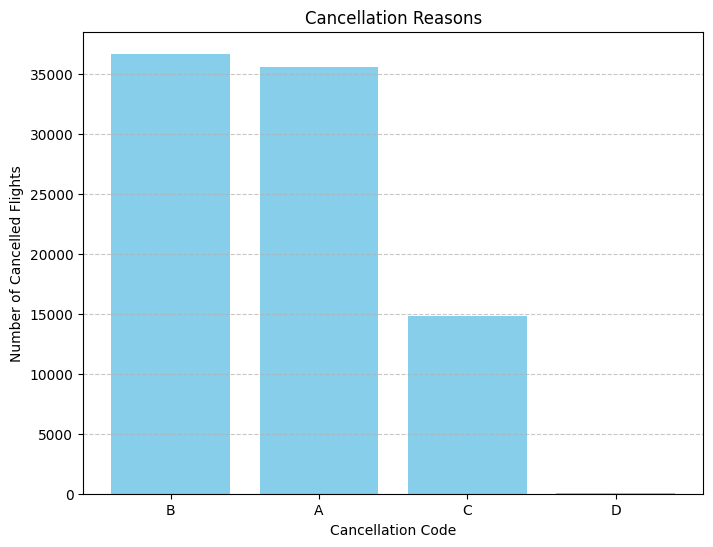

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


cancelled_flights = df.filter(col("CANCELLED") == 1)

cancel_reason_distribution = cancelled_flights.groupBy("CANCELLATION_CODE") \
                                              .agg(count("*").alias("cancel_count")) \
                                              .orderBy(col("cancel_count").desc())


cancel_reason_pd = cancel_reason_distribution.toPandas()

plt.figure(figsize=(8, 6))
plt.bar(cancel_reason_pd['CANCELLATION_CODE'], cancel_reason_pd['cancel_count'], color='skyblue')
plt.xlabel('Cancellation Code')
plt.ylabel('Number of Cancelled Flights')
plt.title('Cancellation Reasons')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

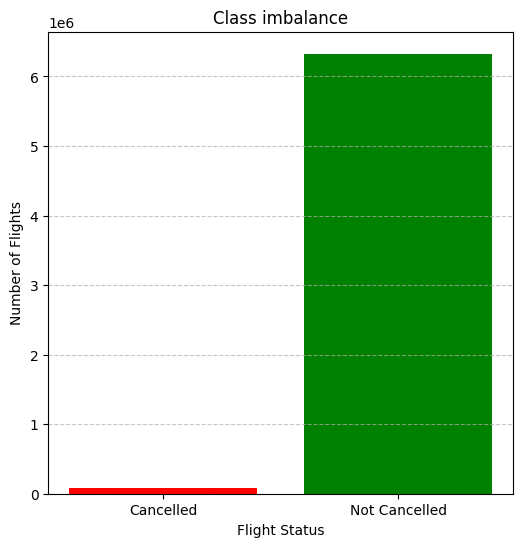

In [ ]:
class_distribution = df.groupBy("CANCELLED") \
                       .agg(count("*").alias("count")) \
                       .orderBy(col("CANCELLED").desc())
class_distribution_pd = class_distribution.toPandas()

class_distribution_pd['Status'] = class_distribution_pd['CANCELLED'].map({
    0: 'Not Cancelled',
    1: 'Cancelled'
})

plt.figure(figsize=(6, 6))
plt.bar(class_distribution_pd['Status'], class_distribution_pd['count'], color=['red', 'green'])
plt.xlabel('Flight Status')
plt.ylabel('Number of Flights')
plt.title('Class imbalance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 4. Feature Engineering

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df = spark.read.parquet("2009_clean")

feature_cols = [
    "UniqueCarrier", "FlightNum", "ORIGIN", "DEST", 
    "CRS_DEP_TIME", "CRS_ARR_TIME", "DayOfWeek", "Month", "DISTANCE"
]

categorical_cols = ["UniqueCarrier", "ORIGIN", "DEST"]

print("Categorical columns to be indexed and one-hot encoded:")
print(categorical_cols)

indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") for col in categorical_cols]

encoders = [OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec") for col in categorical_cols]


final_features = [col + "_Vec" for col in categorical_cols] + ["FlightNum", "CRS_DEP_TIME", "CRS_ARR_TIME", "DayOfWeek", "Month", "DISTANCE"]

print("Final feature columns (categorical encoded + numeric):")
print(final_features)

assembler = VectorAssembler(inputCols=final_features, outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])

pipeline_model = pipeline.fit(df)
prepared_df = pipeline_model.transform(df)

prepared_df.select("features", "CANCELLED").show(5, truncate=False)


Categorical columns to be indexed and one-hot encoded:
['UniqueCarrier', 'ORIGIN', 'DEST']
Final feature columns (categorical encoded + numeric):
['UniqueCarrier_Vec', 'ORIGIN_Vec', 'DEST_Vec', 'FlightNum', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DayOfWeek', 'Month', 'DISTANCE']


+------------------------------------------------------------------------------------------+---------+
|features                                                                                  |CANCELLED|
+------------------------------------------------------------------------------------------+---------+
|(617,[10,66,315,611,612,613,614,615,616],[1.0,1.0,1.0,852.0,830.0,1055.0,4.0,9.0,425.0])  |0.0      |
|(617,[10,19,433,611,612,613,614,615,616],[1.0,1.0,1.0,854.0,2006.0,2240.0,4.0,9.0,1027.0])|0.0      |
|(617,[10,63,315,611,612,613,614,615,616],[1.0,1.0,1.0,854.0,1605.0,1927.0,4.0,9.0,813.0]) |0.0      |
|(617,[10,19,339,611,612,613,614,615,616],[1.0,1.0,1.0,855.0,1130.0,1202.0,4.0,9.0,332.0]) |0.0      |
|(617,[10,43,315,611,612,613,614,615,616],[1.0,1.0,1.0,855.0,1240.0,1501.0,4.0,9.0,332.0]) |0.0      |
+------------------------------------------------------------------------------------------+---------+
only showing top 5 rows



## 5. Modeling

In [9]:
# COMMENT OUT THIS VERSION
# from pyspark.ml.classification import (
#     LogisticRegression,
#     DecisionTreeClassifier,
#     RandomForestClassifier,
#     GBTClassifier,
# )
# from pyspark.ml.evaluation import (
#     BinaryClassificationEvaluator,
#     MulticlassClassificationEvaluator,
# )

# data = prepared_df.withColumnRenamed("CANCELLED", "label")\
#                   .select("features", "label")  
# train_df, test_df = data.randomSplit([0.7, 0.3], seed=42)

# lr  = LogisticRegression(featuresCol="features", labelCol="label", regParam=0.01)
# dt  = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5)
# rf  = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20)
# gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=10)

# binary_evaluator = BinaryClassificationEvaluator(
#     labelCol="label", metricName="areaUnderROC"
# )
# acc_evaluator = MulticlassClassificationEvaluator(
#     labelCol="label", metricName="accuracy"
# )

# models = {
#     "LogisticRegression": lr.fit(train_df),
#     "DecisionTree"      : dt.fit(train_df),
#     "RandomForest"      : rf.fit(train_df),
#     "GBT"               : gbt.fit(train_df),
# }

# print(f"{'Model':<20}  {'Test AUC':>8}  {'Test Acc':>8}")
# for name, model in models.items():
#     preds = model.transform(test_df)
#     auc  = binary_evaluator.evaluate(preds)
#     acc  = acc_evaluator.evaluate(preds)
#     print(f"{name:<20}  {auc:8.4f}  {acc:8.4f}")

In [ ]:
# UNCOMMENT FOR CROSSVALIDATION EDITION
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
)
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)


data = prepared_df.withColumnRenamed("CANCELLED", "label")\
                  .select("features", "label")  
train_df, test_df = data.randomSplit([0.7, 0.3], seed=42)

train_df = train_df.sample(fraction=0.1, seed=42)
test_df = test_df.sample(fraction=0.1, seed=42)


lr  = LogisticRegression(featuresCol="features", labelCol="label")
dt  = DecisionTreeClassifier(featuresCol="features", labelCol="label")
rf  = RandomForestClassifier(featuresCol="features", labelCol="label")
gbt = GBTClassifier(featuresCol="features", labelCol="label")

lr_grid  = ParamGridBuilder()\
           .addGrid(lr.regParam, [0.01, 0.1])\
           .build()

dt_grid  = ParamGridBuilder()\
           .addGrid(dt.maxDepth, [5, 10])\
           .build()

rf_grid  = ParamGridBuilder()\
           .addGrid(rf.numTrees, [20, 50])\
           .build()

gbt_grid = ParamGridBuilder()\
           .addGrid(gbt.maxIter, [10, 20])\
           .build()

binary_evaluator = BinaryClassificationEvaluator(
    labelCol="label", metricName="areaUnderROC"
)
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", metricName="accuracy"
)

cv_lr  = CrossValidator(estimator=lr,  estimatorParamMaps=lr_grid,  evaluator=binary_evaluator, numFolds=3, parallelism=1)
cv_dt  = CrossValidator(estimator=dt,  estimatorParamMaps=dt_grid,  evaluator=binary_evaluator, numFolds=3, parallelism=1)
cv_rf  = CrossValidator(estimator=rf,  estimatorParamMaps=rf_grid,  evaluator=binary_evaluator, numFolds=3, parallelism=1)
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_grid, evaluator=binary_evaluator, numFolds=3, parallelism=1)

models = {
    "LogisticRegression": cv_lr.fit(train_df),
    "DecisionTree"      : cv_dt.fit(train_df),
    "RandomForest"      : cv_rf.fit(train_df),
    "GBT"               : cv_gbt.fit(train_df),
}

print(f"{'Model':<20}  {'Test AUC':>8}  {'Test Acc':>8}")
models = {}

for name, cv in [
    ("LogisticRegression", cv_lr),
    ("DecisionTree", cv_dt),
    ("RandomForest", cv_rf),
    ("GBT", cv_gbt),
]:
    print(f"Training {name}...")
    model = cv.fit(train_df)
    models[name] = model

    preds = model.transform(test_df)
    auc = binary_evaluator.evaluate(preds)
    acc = acc_evaluator.evaluate(preds)

    print(f"{name:<20}  {auc:8.4f}  {acc:8.4f}")



Model                 Test AUC  Test Acc
Training LogisticRegression...


LogisticRegression      0.6995    0.9865
Training DecisionTree...


DecisionTree            0.4009    0.9865
Training RandomForest...


RandomForest            0.6316    0.9865
Training GBT...


GBT                     0.7255    0.9865


## 6. Explainability

In [11]:
# COMMENT OUT THIS VERSION
# tree_models = {k: v for k, v in models.items() if k in ["RandomForest", "GBT"]}

# best_tree_name = None
# best_auc = -1
# for name, model in tree_models.items():
#     preds = model.transform(test_df)
#     auc = binary_evaluator.evaluate(preds)
#     print(f"{name} AUC: {auc:.4f}")
#     if auc > best_auc:
#         best_auc = auc
#         best_tree_name = name

# best_tree_model = tree_models[best_tree_name]
# print(f"\n Best tree-based model: {best_tree_name}")

In [12]:
# UNCOMMENT FOR CROSSVALIDATION EDITION
tree_models = {k: v for k, v in models.items() if k in ["RandomForest", "GBT"]}

best_tree_name = None
best_auc = -1
for name, cv_model in tree_models.items():
    preds = cv_model.bestModel.transform(test_df)
    auc = binary_evaluator.evaluate(preds)
    print(f"{name} AUC: {auc:.4f}")
    if auc > best_auc:
        best_auc = auc
        best_tree_name = name

best_tree_model = tree_models[best_tree_name].bestModel
print(f"\nBest tree-based model: {best_tree_name}")


RandomForest AUC: 0.6316


GBT AUC: 0.7254

Best tree-based model: GBT


                  feature  importance
615                 Month    0.206481
614             DayOfWeek    0.072812
612          CRS_DEP_TIME    0.066833
611             FlightNum    0.066463
616              DISTANCE    0.066125
334          DEST_Vec_LGA    0.055782
613          CRS_ARR_TIME    0.036720
0    UniqueCarrier_Vec_WN    0.036565
38         ORIGIN_Vec_LGA    0.035039
33         ORIGIN_Vec_EWR    0.032805


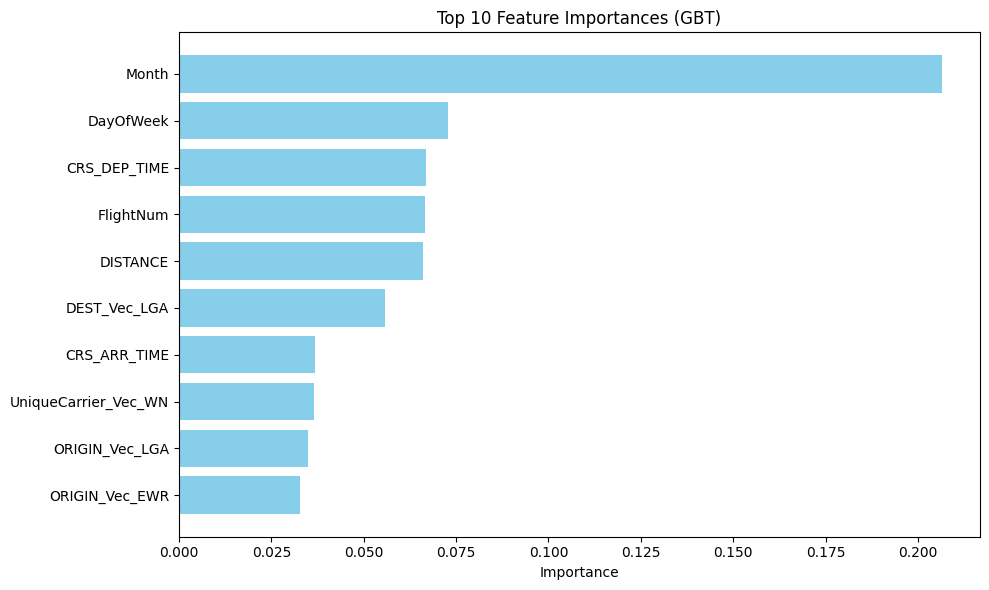

In [ ]:
attrs = prepared_df.schema["features"].metadata["ml_attr"]["attrs"]

all_attrs = attrs.get("binary", []) + attrs.get("numeric", [])
all_attrs = sorted(all_attrs, key=lambda x: x["idx"])

vector_feature_names = [a["name"] for a in all_attrs]

importance_df = pd.DataFrame({
    "feature": vector_feature_names,
    "importance": best_tree_model.featureImportances.toArray()
}).sort_values("importance", ascending=False)

top10 = importance_df.head(10)
print(top10)

plt.figure(figsize=(10,6))
plt.barh(top10["feature"][::-1], top10["importance"][::-1], color="skyblue")
plt.xlabel("Importance")
plt.title(f"Top 10 Feature Importances ({best_tree_name})")
plt.tight_layout()
plt.show()

## 7. Model Persistence and Inference

In [14]:
from pyspark.ml import PipelineModel

full_pipe = PipelineModel(
    stages = pipeline_model.stages   
           + [ best_tree_model ]
)

full_pipe.write().overwrite().save("model/best_pipeline_model")  
print("Full pipeline + model saved to 'model/best_pipeline_model'")
loaded_pipe = PipelineModel.load("model/best_pipeline_model")


Full pipeline + model saved to 'model/best_pipeline_model'


In [15]:
from pyspark.sql.functions import col, to_date, year, month, dayofweek

df10_raw = spark.read.csv("2010.csv", header=True, inferSchema=True)

df10 = (
    df10_raw
      .withColumn("FL_DATE", to_date(col("FL_DATE"), "yyyy-MM-dd"))
      .filter(year("FL_DATE")==2010)
      .withColumnRenamed("OP_CARRIER", "UniqueCarrier")
      .withColumnRenamed("OP_CARRIER_FL_NUM", "FlightNum")
      .withColumn("DayOfWeek", dayofweek("FL_DATE"))
      .withColumn("Month", month("FL_DATE"))
      .dropna(subset=["UniqueCarrier","FlightNum","ORIGIN","DEST","CRS_DEP_TIME","CRS_ARR_TIME"])
      .filter(col("DIVERTED")==0)
)

In [16]:
pred10 = loaded_pipe.transform(df10)

pred10.select(
    "UniqueCarrier","ORIGIN","DEST",
    "rawPrediction","probability","prediction"
).show(5, truncate=False)

+-------------+------+----+----------------------------------------+-----------------------------------------+----------+
|UniqueCarrier|ORIGIN|DEST|rawPrediction                           |probability                              |prediction|
+-------------+------+----+----------------------------------------+-----------------------------------------+----------+
|MQ           |LGA   |RDU |[1.3514526901450405,-1.3514526901450405]|[0.9371978662614987,0.0628021337385013]  |0.0       |
|MQ           |DCA   |JFK |[1.3601216936403573,-1.3601216936403573]|[0.9382106447502586,0.061789355249741384]|0.0       |
|MQ           |LGA   |RDU |[1.3618892741278512,-1.3618892741278512]|[0.9384152658892334,0.06158473411076659] |0.0       |
|MQ           |RDU   |LGA |[1.3168830281334136,-1.3168830281334136]|[0.9330033426864767,0.06699665731352333] |0.0       |
|MQ           |JFK   |DCA |[1.3600811317081565,-1.3600811317081565]|[0.9382059417165779,0.061794058283422104]|0.0       |
+-------------+------+--

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

pred10 = pred10.withColumnRenamed("CANCELLED","label")

b_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label")
m_evaluator = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label")

print("2010 AUC: ", b_evaluator.evaluate(pred10))
print("2010 Acc: ", m_evaluator.evaluate(pred10))

2010 AUC:  0.6917447448084143


2010 Acc:  0.9823422993319132
